In [1]:
import pandas as pd
import numpy as np
import sklearn
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import datetime
import torch.nn.functional as F
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import BinaryAccuracy
from sklearn.model_selection import train_test_split
import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from torch.nn import BCELoss
import torch.nn.init as init
import random
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [2]:
#Set seeds to allow for reproducibility of the results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
#Open the expression data as a pandas data frame
mirna_path = "/home/bettimj/gamazon_rotation/deep_learning_tcga_lc/data/all_common_samples_mirna_scc_ad_combined_no_na.txt"

mirna_file = pd.read_csv(mirna_path, sep = "\t")
mirna_file = mirna_file.sample(frac=1)
mirna_file

,sample,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,...,hsa-mir-941-1,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,hist
590,TCGA-69-7978-01A,-0.666591,-0.663185,-0.674511,-0.490324,-0.748631,-0.194442,-0.562060,-0.691977,-0.697597,...,-0.126513,-0.484846,-0.468580,-0.284979,-0.368258,-0.804095,-0.622836,-0.732972,-0.233977,ad
278,TCGA-49-AARN-01A,-0.187578,-0.196456,-0.189710,-0.149066,-0.476407,0.251636,-0.089567,-0.276091,-0.263728,...,-0.126513,-0.250808,-0.468580,-0.104186,-0.192294,0.601123,-0.032238,0.267776,0.161825,ad
14,TCGA-05-4410-01A,-0.074787,-0.067787,-0.075724,0.101507,0.090464,-0.130459,-0.176394,-0.197053,-0.190188,...,-0.126513,0.685345,-0.468580,-0.219236,-0.544222,-0.183004,-0.491235,0.197348,-0.219923,ad
678,TCGA-78-7154-01A,-0.007959,-0.012544,-0.008102,-0.412007,-0.499279,-0.525622,0.225478,0.329108,0.315968,...,-0.126513,-0.406833,-0.468580,-0.301415,-0.438644,-0.214059,-0.382103,-0.650471,-0.413059,ad
338,TCGA-55-6970-01A,0.986980,0.983292,0.997317,2.019413,0.078953,2.436969,-0.013147,0.334198,0.342243,...,-0.126513,1.933549,-0.468580,-0.137058,2.587937,1.315378,1.193896,0.383144,0.458622,ad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,TCGA-95-7944-01A,-0.816502,-0.824754,-0.818192,-0.681011,-0.942072,-0.516610,-0.974934,-0.757552,-0.756746,...,-0.126513,0.646339,-0.468580,-0.334286,1.848888,0.368214,-0.792954,-0.960354,-0.485139,ad
192,TCGA-43-8116-01A,-0.318021,-0.329667,-0.320188,-0.513395,1.219466,-0.602201,-0.491047,-0.432977,-0.418381,...,-0.202153,0.964210,3.029515,-0.065644,1.509668,-0.062550,-0.538266,1.223425,-0.500273,scc
629,TCGA-77-7138-01A,0.528765,0.542775,0.530402,1.382113,-0.616685,-0.028819,0.116164,-0.000838,-0.001634,...,-0.202153,0.153191,-0.487547,-0.273168,1.509668,-0.734111,0.441802,-0.665758,-0.462748,scc
559,TCGA-66-2787-01A,-0.891007,-0.887445,-0.895885,-0.891075,-0.790554,-0.953438,-0.859753,-0.890582,-0.894280,...,-0.202153,-0.854439,-0.487547,-0.642253,-0.574265,-0.171678,-1.057507,-0.805896,-0.963885,scc


In [4]:
#Prepare training, validation, and test data

train = mirna_file.iloc[:,1:]
train_features = train.copy()
train_labels = train_features.pop('hist')
train_labels

train_labels = list(map(lambda x: x.replace('ad', '0'), train_labels))
train_labels = list(map(lambda x: x.replace('scc', '1'), train_labels))

train_labels = [int(x) for x in train_labels]
train_labels = np.array(train_labels)

train_labels

train_set_final, test_set_prelim, train_labels_final, test_labels_prelim = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)
val_set_final, test_set_final, val_labels_final, test_labels_final = train_test_split(test_set_prelim, test_labels_prelim, test_size=0.5, random_state=42)

In [5]:
train_set_final = np.array(train_set_final)
train_set_final = torch.tensor(train_set_final, dtype=torch.float32)
train_set_final.shape

train_labels_final = np.array(train_labels_final)
train_labels_final = torch.tensor(train_labels_final, dtype=torch.float32)
train_labels_final.shape

torch.Size([769])

In [6]:
val_set_final = np.array(val_set_final)
val_set_final = torch.tensor(val_set_final, dtype=torch.float32)
val_set_final.shape

val_labels_final = np.array(val_labels_final)
val_labels_final = torch.tensor(val_labels_final, dtype=torch.float32)
val_labels_final.shape

torch.Size([96])

In [7]:
test_set_final = np.array(test_set_final)
test_set_final = torch.tensor(test_set_final, dtype=torch.float32)
test_set_final.shape

torch.Size([97, 1534])

In [8]:
train_features = np.array(train_features)
train_features = torch.tensor(train_features, dtype = torch.float32)

In [9]:
torch.cuda.is_available()

True

In [10]:
#Optimizng the number of neurons in each hidden layer - starting network has one hidden layer
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=60,
    module__num_hidden_layers=1,
    module__output_size=1,
    verbose=False,
    device = "cuda"
)

# Define the grid of model parameters to search over
param_grid = {
    'module__hidden_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.560367 using {'module__hidden_size': 30}
0.521455 (0.061006) with: {'module__hidden_size': 10}
0.547304 (0.078858) with: {'module__hidden_size': 20}
0.560367 (0.057035) with: {'module__hidden_size': 30}
0.560359 (0.063387) with: {'module__hidden_size': 40}
0.557610 (0.059813) with: {'module__hidden_size': 50}
0.539376 (0.054502) with: {'module__hidden_size': 60}
0.552977 (0.065026) with: {'module__hidden_size': 70}
0.555302 (0.047736) with: {'module__hidden_size': 80}
0.553928 (0.045420) with: {'module__hidden_size': 90}
0.553703 (0.056967) with: {'module__hidden_size': 100}


In [11]:
#Optimizng the number hidden layers - starting network has one hidden layer, so the actual number of hidden layers in grid search models is module__num_hidden_layers + 1
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=30,
    module__num_hidden_layers=1,
    module__output_size=1,
    verbose=False,
    device = "cuda"
)

# Define the grid of model parameters to search over
param_grid = {
    'module__num_hidden_layers': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.639944 using {'module__num_hidden_layers': 3}
0.556954 (0.058061) with: {'module__num_hidden_layers': 1}
0.637862 (0.054223) with: {'module__num_hidden_layers': 2}
0.639944 (0.057990) with: {'module__num_hidden_layers': 3}
0.617078 (0.058574) with: {'module__num_hidden_layers': 4}
0.631005 (0.059287) with: {'module__num_hidden_layers': 5}
0.632283 (0.064013) with: {'module__num_hidden_layers': 6}
0.617664 (0.033578) with: {'module__num_hidden_layers': 7}
0.603724 (0.017464) with: {'module__num_hidden_layers': 8}
0.608802 (0.092467) with: {'module__num_hidden_layers': 9}
0.603615 (0.024926) with: {'module__num_hidden_layers': 10}


In [12]:
#Optimizng the batch size and number of epochs
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=30,
    module__num_hidden_layers=3,
    module__output_size=1,
    verbose=False,
    device = "cuda"
)

# Define the grid of model parameters to search over
param_grid = {
    'batch_size':[10, 20, 40, 60, 80, 100],
    'max_epochs': [10, 20, 30, 40, 50],
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best: 0.684256 using {'batch_size': 20, 'max_epochs': 20}
0.645041 (0.054326) with: {'batch_size': 10, 'max_epochs': 10}
0.670867 (0.035286) with: {'batch_size': 10, 'max_epochs': 20}
0.671368 (0.050679) with: {'batch_size': 10, 'max_epochs': 30}
0.635775 (0.068205) with: {'batch_size': 10, 'max_epochs': 40}
0.664112 (0.027437) with: {'batch_size': 10, 'max_epochs': 50}
0.635603 (0.021985) with: {'batch_size': 20, 'max_epochs': 10}
0.684256 (0.048352) with: {'batch_size': 20, 'max_epochs': 20}
0.670376 (0.075099) with: {'batch_size': 20, 'max_epochs': 30}
0.674049 (0.043539) with: {'batch_size': 20, 'max_epochs': 40}
0.627762 (0.059443) with: {'batch_size': 20, 'max_epochs': 50}
0.627033 (0.075593) with: {'batch_size': 40, 'max_epochs': 10}
0.663252 (0.050664) with: {'batch_size': 40, 'max_epochs': 20}
0.648226 (0.061774) with: {'batch_size': 40, 'max_epochs': 30}
0.645555 (0.065203) with: {'batch_size': 40, 'max_epochs': 40

In [13]:
#Optimizng the training optimization algorithm
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    max_epochs=20,
    batch_size=20,
    module__input_size=input_shape,
    module__hidden_size=30,
    module__num_hidden_layers=3,
    module__output_size=1,
    verbose=False,
    device = "cuda"
)

# Define the grid of model parameters to search over
param_grid = {
    'optimizer':[optim.SGD, optim.RMSprop, optim.Adagrad, optim.Adadelta,
                  optim.Adam, optim.Adamax, optim.NAdam]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best: 0.688853 using {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>}
0.484864 (0.024851) with: {'optimizer': <class 'torch.optim.sgd.SGD'>}
0.688853 (0.047404) with: {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>}
0.632427 (0.042988) with: {'optimizer': <class 'torch.optim.adagrad.Adagrad'>}
0.498099 (0.045627) with: {'optimizer': <class 'torch.optim.adadelta.Adadelta'>}
0.679310 (0.052625) with: {'optimizer': <class 'torch.optim.adam.Adam'>}
0.671760 (0.055201) with: {'optimizer': <class 'torch.optim.adamax.Adamax'>}
0.661893 (0.074332) with: {'optimizer': <class 'torch.optim.nadam.NAdam'>}


In [14]:
#Optimizng the learning rate and momentum
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.RMSprop,
    max_epochs=20,
    batch_size=20,
    module__input_size=input_shape,
    module__hidden_size=30,
    module__num_hidden_layers=3,
    module__output_size=1,
    verbose=False,
    device = "cuda"
)

# Define the grid of model parameters to search over
param_grid = {
    'optimizer__lr': [0.0001, 0.0005 ,0.001, 0.005, 0.01, 0.1, 0.2, 0.3],
    #'optimizer__momentum': [0.0, 0.2, 0.4, 0.6, 0.8, 0.9],
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best: 0.667537 using {'optimizer__lr': 0.01}
0.587821 (0.057480) with: {'optimizer__lr': 0.0001}
0.608888 (0.036576) with: {'optimizer__lr': 0.0005}
0.629516 (0.045357) with: {'optimizer__lr': 0.001}
0.656761 (0.058617) with: {'optimizer__lr': 0.005}
0.667537 (0.064942) with: {'optimizer__lr': 0.01}
0.500000 (0.000000) with: {'optimizer__lr': 0.1}
0.500000 (0.000000) with: {'optimizer__lr': 0.2}
0.500000 (0.000000) with: {'optimizer__lr': 0.3}


In [19]:
#Optimizng how the weights are initialized
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        # manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.RMSprop,
    max_epochs=20,
    batch_size=20,
    module__input_size=input_shape,
    module__hidden_size=30,
    module__num_hidden_layers=3,
    module__output_size=1,
    optimizer__lr = 0.01,
    verbose=False,
    device = "cuda"
)

# Define the grid of model parameters to search over
param_grid = {
    'module__weight_init_hidden': [init.uniform_, init.normal_, init.zeros_,
                           init.xavier_normal_, init.xavier_uniform_,
                           init.kaiming_normal_, init.kaiming_uniform_],
    'module__weight_init_out': [init.uniform_, init.normal_, init.zeros_,
                           init.xavier_normal_, init.xavier_uniform_,
                           init.kaiming_normal_, init.kaiming_uniform_]
}

# # Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Best: 0.701262 using {'module__weight_init_hidden': <function xavier_uniform_ at 0x2ad1562d2e60>, 'module__weight_init_out': <function normal_ at 0x2ad1562d2950>}
0.480710 (0.056060) with: {'module__weight_init_hidden': <function uniform_ at 0x2ad1562d28c0>, 'module__weight_init_out': <function uniform_ at 0x2ad1562d28c0>}
0.479608 (0.057979) with: {'module__weight_init_hidden': <function uniform_ at 0x2ad1562d28c0>, 'module__weight_init_out': <function normal_ at 0x2ad1562d2950>}
0.513585 (0.058651) with: {'module__weight_init_hidden': <function uniform_ at 0x2ad1562d28c0>, 'module__weight_init_out': <function zeros_ at 0x2ad1562d2c20>}
0.472452 (0.053388) with: {'module__weight_init_hidden': <function uniform_ at 0x2ad1562d28c0>, 'module__weight_init_out': <function xavier_normal_ at 0x2ad1562d2ef0>}
0.488059 (0.058174) with: {'module__weight_init_hidden': <function uniform_ at 0x2ad1562d28c0>, 'module__weight_init_out': <

In [ ]:
#Optimizng the activation function
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = activation()
        # manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)
    def forward(self, x):
        x = self.activation(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = self.activation(self.hidden_layers[i](x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.RMSprop,
    max_epochs=20,
    batch_size=20,
    module__input_size=input_shape,
    module__hidden_size=30,
    module__num_hidden_layers=3,
    module__output_size=1,
    optimizer__lr = 0.01,
    module__weight_init_hidden = init.xavier_uniform_,
    module__weight_init_out = init.normal_,
    verbose=False,
    device = "cuda"
)

# Define the grid of model parameters to search over
param_grid = {
    'module__activation': [nn.Identity, nn.ReLU, nn.LeakyReLU, nn.ELU, nn.ReLU6,
                          nn.GELU, nn.Softplus, nn.Softsign, nn.Tanh,
                          nn.Sigmoid, nn.Hardsigmoid]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best: 0.635577 using {'module__activation': <class 'torch.nn.modules.activation.ELU'>}
0.519600 (0.040059) with: {'module__activation': <class 'torch.nn.modules.linear.Identity'>}
0.606081 (0.090601) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>}
0.555313 (0.072091) with: {'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
0.635577 (0.115750) with: {'module__activation': <class 'torch.nn.modules.activation.ELU'>}
0.602657 (0.089155) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU6'>}
0.611518 (0.086577) with: {'module__activation': <class 'torch.nn.modules.activation.GELU'>}
0.498747 (0.002968) with: {'module__activation': <class 'torch.nn.modules.activation.Softplus'>}
0.440140 (0.036707) with: {'module__activation': <class 'torch.nn.modules.activation.Softsign'>}
0.551871 (0.054943) with: {'module__activation': <class 'torch.nn.modules.activation.Tanh'>}
0.

In [24]:
#Optimizng dropout
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation, dropout_rate1, dropout_rate2, dropout_rate3, weight_constraint):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate1)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate3)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.activation = activation()
        self.weight_constraint = weight_constraint
        # manually init weights
        weight_init_hidden(self.fc1.weight)
        weight_init_hidden(self.fc2.weight)
        weight_init_hidden(self.fc3.weight)
        weight_init_out(self.fc4.weight)
    def forward(self, x):
        # maxnorm weight before actual forward pass
        with torch.no_grad():
            norm = self.fc1.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
            desired = torch.clamp(norm, max=self.weight_constraint)
            self.fc1.weight *= (desired / norm)

            norm = self.fc2.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
            desired = torch.clamp(norm, max=self.weight_constraint)
            self.fc2.weight *= (desired / norm)

            norm = self.fc3.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
            desired = torch.clamp(norm, max=self.weight_constraint)
            self.fc3.weight *= (desired / norm)

        x = self.activation(self.fc1(x))
        x = self.dropout1(x)
        x = self.activation(self.fc2(x))
        x = self.dropout2(x)
        x = self.activation(self.fc3(x))
        x = self.dropout3(x)
        x = torch.sigmoid(self.fc4(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.RMSprop,
    max_epochs=20,
    batch_size=20,
    module__input_size=input_shape,
    module__hidden_size=30,
    module__num_hidden_layers=3,
    module__output_size=1,
    optimizer__lr = 0.01,
    module__weight_init_hidden = init.xavier_uniform_,
    module__weight_init_out = init.normal_,
    module__activation = nn.ELU,
    verbose=False,
    device = "cuda",
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False),
    ]
)

# Define the grid of model parameters to search over
param_grid = {
    'module__dropout_rate1': [0.0, 0.1, 0.3, 0.5],
    'module__dropout_rate2': [0.0, 0.1, 0.3, 0.5],
    'module__dropout_rate3': [0.0, 0.1, 0.3, 0.5],
    'module__weight_constraint': [1.0, 3.0, 5.0, 7.0, 9.0]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best: 0.688722 using {'module__dropout_rate1': 0.3, 'module__dropout_rate2': 0.0, 'module__dropout_rate3': 0.5, 'module__weight_constraint': 1.0}
0.677507 (0.019381) with: {'module__dropout_rate1': 0.0, 'module__dropout_rate2': 0.0, 'module__dropout_rate3': 0.0, 'module__weight_constraint': 1.0}
0.514510 (0.034833) with: {'module__dropout_rate1': 0.0, 'module__dropout_rate2': 0.0, 'module__dropout_rate3': 0.0, 'module__weight_constraint': 3.0}
0.489771 (0.017897) with: {'module__dropout_rate1': 0.0, 'module__dropout_rate2': 0.0, 'module__dropout_rate3': 0.0, 'module__weight_constraint': 5.0}
0.635577 (0.115750) with: {'module__dropout_rate1': 0.0, 'module__dropout_rate2': 0.0, 'module__dropout_rate3': 0.0, 'module__weight_constraint': 7.0}
0.489579 (0.021302) with: {'module__dropout_rate1': 0.0, 'module__dropout_rate2': 0.0, 'module__dropout_rate3': 0.0, 'module__weight_constraint': 9.0}
0.671025 (0.061358) with: {'module_

In [25]:
# #Optimizng L1 and L2 regularization
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)
# n_cols = train_set_final.shape[1]
# input_shape = n_cols

# # Define the neural network model
# class Net(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation, dropout_rate1, dropout_rate2, dropout_rate3, weight_constraint, alpha_l1, alpha_l2):
#         super(Net, self).__init__()
#         self.alpha_l1 = alpha_l1
#         self.alpha_l2 = alpha_l2
        
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.dropout1 = nn.Dropout(dropout_rate1)
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.dropout2 = nn.Dropout(dropout_rate2)
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
#         self.dropout3 = nn.Dropout(dropout_rate3)
#         self.fc4 = nn.Linear(hidden_size, output_size)
#         self.activation = activation()
#         self.weight_constraint = weight_constraint
#         # manually init weights
#         weight_init_hidden(self.fc1.weight)
#         weight_init_hidden(self.fc2.weight)
#         weight_init_hidden(self.fc3.weight)
#         weight_init_out(self.fc4.weight)
#     def forward(self, x):
#         # maxnorm weight before actual forward pass
#         with torch.no_grad():
#             norm = self.fc1.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#             desired = torch.clamp(norm, max=self.weight_constraint)
#             self.fc1.weight *= (desired / norm)

#             norm = self.fc2.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#             desired = torch.clamp(norm, max=self.weight_constraint)
#             self.fc2.weight *= (desired / norm)

#             norm = self.fc3.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#             desired = torch.clamp(norm, max=self.weight_constraint)
#             self.fc3.weight *= (desired / norm)

#         x = self.activation(self.fc1(x))
#         x = self.dropout1(x)
#         x = self.activation(self.fc2(x))
#         x = self.dropout2(x)
#         x = self.activation(self.fc3(x))
#         x = self.dropout3(x)
#         x = torch.sigmoid(self.fc4(x))
#         return x.squeeze()
    
# # Add regularization to the optimizer
# from skorch.utils import to_device
# from skorch.callbacks import Callback
# from skorch.history import History

# class RegularizationCallback(Callback):
#     def __init__(self, alpha_l1=0.01, alpha_l2=0.01, seed_value=0):
#         self.alpha_l1 = alpha_l1
#         self.alpha_l2 = alpha_l2
#         #self.seed_value = seed_value

#     def on_train_begin(self, net, X, y):
#         #torch.manual_seed(self.seed_value)
#         self.optimizer = net.optimizer_

#     def on_epoch_end(self, net, dataset_train, dataset_valid=None, **kwargs):
#         # Apply L1 regularization
#         for param in net.module_.parameters():
#             if param.requires_grad:
#                 param.data = to_device(param.data, device=net.device)
#                 param.data = param.data - self.alpha_l1 * torch.sign(param.data)

#         # Apply L2 regularization
#         for param in net.module_.parameters():
#             if param.requires_grad:
#                 param.data = to_device(param.data, device=net.device)
#                 param.data = param.data - self.alpha_l2 * param.data

#         # Update optimizer state with new parameter values
#         self.optimizer.state = net.optimizer_.state

#         # Add regularization loss to history
#         history = net.history
#         if 'reg_loss' not in history:
#             history.new_epoch()
#         history.record('reg_loss', self.alpha_l1 * sum([torch.norm(param, p=1) for param in net.module_.parameters() if param.requires_grad]) + 
#                               self.alpha_l2 * sum([torch.norm(param, p=2) for param in net.module_.parameters() if param.requires_grad]))
    
# model = NeuralNetClassifier(
#     Net,
#     criterion=BCELoss,
#     optimizer=optim.RMSprop,
#     max_epochs=20,
#     batch_size=20,
#     module__input_size=input_shape,
#     module__hidden_size=30,
#     module__num_hidden_layers=3,
#     module__output_size=1,
#     optimizer__lr = 0.01,
#     module__weight_init_hidden = init.xavier_uniform_,
#     module__weight_init_out = init.normal_,
#     module__activation = nn.ELU,
#     module__dropout_rate1 = 0.3,
#     module__dropout_rate2=0.0,
#     module__dropout_rate3=0.5,
#     module__weight_constraint = 1.0,
#     verbose=False,
#     device = "cuda",
#     callbacks=[
#         EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
#         EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False),
#         RegularizationCallback(alpha_l1 = 0.01, alpha_l2 = 0.01)
#     ]
# )

# # Define the grid of model parameters to search over
# param_grid = {
#     'module__alpha_l1': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
#     'module__alpha_l2': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
# }

# # Create a GridSearchCV object and fit it to the training data
# split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
# X = torch.cat((train_set_final, val_set_final), axis=0)
# y = torch.cat((train_labels_final, val_labels_final), axis=0)
# pds = PredefinedSplit(test_fold = split_index)

# clf = GridSearchCV(estimator=model,
#                    cv=KFold(5, random_state=0, shuffle=True),
#                    param_grid=param_grid,
#                    scoring = "roc_auc",
#                    n_jobs=1,
#                    verbose=1)

# # Fit with all data
# grid_result = clf.fit(X, y.float())

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Text(0.5, 1.0, 'Training and Validation AUC')

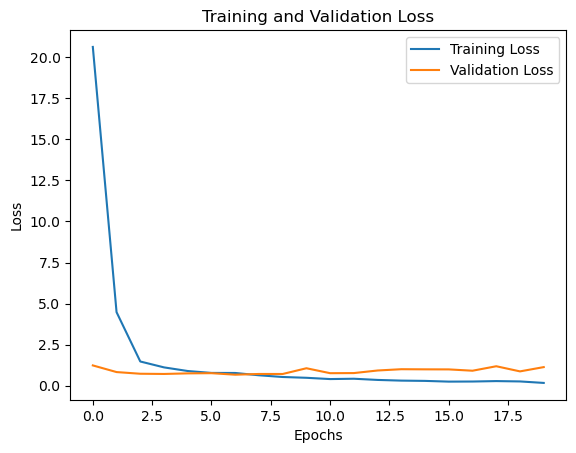

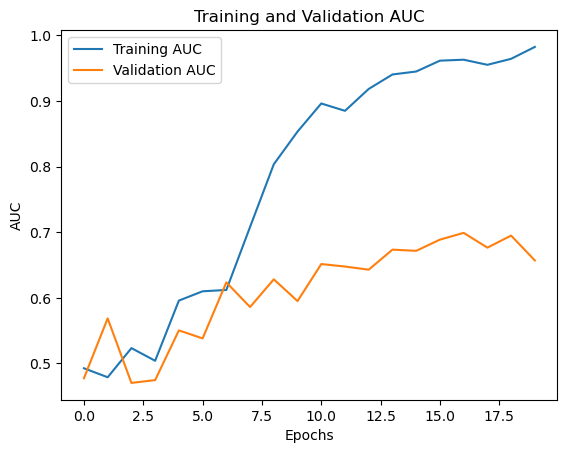

In [26]:
import matplotlib.pyplot as plt

# get the best estimator
best_estimator = grid_result.best_estimator_
#print(best_estimator.history)

# get training and validation loss and AUC
train_loss = best_estimator.history[:, 'train_loss']
val_loss = best_estimator.history[:, 'valid_loss']
train_auc = best_estimator.history[:, 'train_auc']
val_auc = best_estimator.history[:, 'valid_auc']

# plot the training and validation loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# plot the training and validation AUC curves
plt.figure()
plt.plot(train_auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')

In [27]:
best_estimator = grid_result.best_estimator_
print(best_estimator)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (fc1): Linear(in_features=1534, out_features=30, bias=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (fc2): Linear(in_features=30, out_features=30, bias=True)
    (dropout2): Dropout(p=0.0, inplace=False)
    (fc3): Linear(in_features=30, out_features=30, bias=True)
    (dropout3): Dropout(p=0.5, inplace=False)
    (fc4): Linear(in_features=30, out_features=1, bias=True)
    (activation): ELU(alpha=1.0)
  ),
)


In [28]:
best_model = grid_result.best_estimator_.module_
# Save the best model to HDF5 format
torch.save(best_model.state_dict(), 'best_mirna_expression_model.h5')

In [29]:
# Evaluate performance on test set
y_pred = best_model(test_set_final.to("cuda"))
auc = roc_auc_score(test_labels_final, y_pred.detach().cpu().numpy())

print(auc)

0.6190900981266726


In [17]:
# #Optimizng convolutions
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)
# n_cols = train_set_final.shape[1]
# input_shape = n_cols

# class Net(nn.Module):
#     def __init__(self, input_size, conv_num_filters, conv_kernel_size, conv_padding, pool_kernel_size, pool_stride, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation, dropout_rate, weight_constraint, alpha_l1, alpha_l2, batch_size=20):
#         super(Net, self).__init__()
        
#         self.batch_size = batch_size
#         self.conv_num_filters = conv_num_filters
#         self.conv_kernel_size = conv_kernel_size
#         self.conv_padding = conv_padding
#         self.batch_size = batch_size
#         self.pool_kernel_size = pool_kernel_size
#         self.pool_stride = pool_stride

#         # Define the convolutional and max pooling layers
#         conv_layers = nn.Sequential(
#             nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=conv_padding),
#             nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
#         )
        
#         # Generate some random input
#         z = torch.randn(1, input_shape)
        
#         # Pass the input through the convolutional layers
#         conv_out = conv_layers(z)

#         # Calculate the number of features in the output of the last convolutional layer
#         fc1_in_size = torch.flatten(conv_out, start_dim = 0, end_dim = 1).shape[0]
#         self.fc1_in_size = fc1_in_size
#         #print("fc1 in size:")
#         print(fc1_in_size)
        
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=self.conv_padding)
#         self.pool1 = nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        
#         self.alpha_l1 = alpha_l1
#         self.alpha_l2 = alpha_l2
#         self.fc1 = nn.Linear(self.fc1_in_size, hidden_size)
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
#         self.dropout3 = nn.Dropout(dropout_rate)
#         self.fc4 = nn.Linear(hidden_size, output_size)
#         self.activation = activation()
#         self.weight_constraint = weight_constraint
#         # manually init weights
#         weight_init_hidden(self.fc1.weight)
#         weight_init_hidden(self.fc2.weight)
#         weight_init_hidden(self.fc3.weight)
#         weight_init_out(self.fc4.weight)
    
#     def forward(self, x):
#         batch_size = x.shape[0]
#         # maxnorm weight before actual forward pass
#         with torch.no_grad():
#             norm = self.fc1.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#             desired = torch.clamp(norm, max=self.weight_constraint)
#             self.fc1.weight *= (desired / norm)

#             norm = self.fc2.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#             desired = torch.clamp(norm, max=self.weight_constraint)
#             self.fc2.weight *= (desired / norm)

#             norm = self.fc3.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#             desired = torch.clamp(norm, max=self.weight_constraint)
#             self.fc3.weight *= (desired / norm)

#         out = []
#         for i in range(batch_size):
#             x_batch = x[i].unsqueeze(0)
#             x_batch = self.activation(self.conv1(x_batch))
#             x_batch = self.pool1(x_batch)
#             x_batch = torch.flatten(x_batch, start_dim = 0, end_dim = 1)
#             #print("x_batch shape:")
#             #print(x_batch.shape)
#             x_batch = self.activation(self.fc1(x_batch))
#             x_batch = self.dropout1(x_batch)
#             x_batch = self.activation(self.fc2(x_batch))
#             x_batch = self.dropout2(x_batch)
#             x_batch = self.activation(self.fc3(x_batch))
#             x_batch = self.dropout3(x_batch)
#             x_batch = torch.sigmoid(self.fc4(x_batch))
#             out.append(x_batch.squeeze())
#         return torch.stack(out, dim=0)
    
# # Add regularization to the optimizer
# from skorch.utils import to_device
# from skorch.callbacks import Callback
# from skorch.history import History

# class RegularizationCallback(Callback):
#     def __init__(self, alpha_l1=0.01, alpha_l2=0.01):
#         self.alpha_l1 = alpha_l1
#         self.alpha_l2 = alpha_l2

#     def on_train_begin(self, net, X, y):
#         self.optimizer = net.optimizer_

#     def on_epoch_end(self, net, dataset_train, dataset_valid=None, **kwargs):
#         # Apply L1 regularization
#         for param in net.module_.parameters():
#             if param.requires_grad:
#                 param.data = to_device(param.data, device=net.device)
#                 param.data = param.data - self.alpha_l1 * torch.sign(param.data)

#         # Apply L2 regularization
#         for param in net.module_.parameters():
#             if param.requires_grad:
#                 param.data = to_device(param.data, device=net.device)
#                 param.data = param.data - self.alpha_l2 * param.data

#         # Update optimizer state with new parameter values
#         self.optimizer.state = net.optimizer_.state

#         # Add regularization loss to history
#         history = net.history
#         if 'reg_loss' not in history:
#             history.new_epoch()
#         history.record('reg_loss', self.alpha_l1 * sum([torch.norm(param, p=1) for param in net.module_.parameters() if param.requires_grad]) + 
#                               self.alpha_l2 * sum([torch.norm(param, p=2) for param in net.module_.parameters() if param.requires_grad]))
    
# model = NeuralNetClassifier(
#     Net,
#     criterion=BCELoss,
#     optimizer=optim.Adagrad,
#     max_epochs=20,
#     batch_size=20,
#     module__input_size=input_shape,
#     module__hidden_size=10,
#     module__num_hidden_layers=4,
#     module__output_size=1,
#     optimizer__lr = 0.01,
#     module__weight_init_hidden = init.xavier_uniform_,
#     module__weight_init_out = init.zeros_,
#     module__activation = nn.GELU,
#     module__dropout_rate = 0.0,
#     module__weight_constraint = 8.0,
#     module__alpha_l1 = 0,
#     module__alpha_l2 = 0.001,
#     verbose=True,
#     device = "cuda",
#     callbacks=[
#         EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
#         EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False),
#         RegularizationCallback(alpha_l1 = 0.01, alpha_l2 = 0.01)
#     ]
# )

# # Define the grid of model parameters to search over
# param_grid = {
#     'module__conv_num_filters': [8, 16, 32, 64],
#     'module__conv_kernel_size': [3, 5, 7],
#     'module__conv_padding': [0, 1, 2],
#     'module__pool_kernel_size': [2, 3, 4],
#     'module__pool_stride': [1, 2, 3] 
# }

# # Create a GridSearchCV object and fit it to the training data
# split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
# X = torch.cat((train_set_final, val_set_final), axis=0)
# X.unsqueeze(0)
# y = torch.cat((train_labels_final, val_labels_final), axis=0)
# pds = PredefinedSplit(test_fold = split_index)

# clf = GridSearchCV(estimator=model,
#                    cv=KFold(5, random_state=0, shuffle=True),
#                    param_grid=param_grid,
#                    scoring = "roc_auc",
#                    n_jobs=1,
#                    verbose=1)

# # Fit with all data
# grid_result = clf.fit(X, y.float())

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [33]:
import torch
import shap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.cat((train_set_final, val_set_final), axis=0).to(device)

criterion=BCELoss,
    optimizer=optim.RMSprop,
    max_epochs=20,
    batch_size=20,
    module__input_size=input_shape,
    module__hidden_size=30,
    module__num_hidden_layers=3,
    module__output_size=1,
    optimizer__lr = 0.01,
    module__weight_init_hidden = init.xavier_uniform_,
    module__weight_init_out = init.normal_,
    module__activation = nn.ELU,

class Net(nn.Module):
    def __init__(self, input_size=1534, hidden_size=30, output_size=1, num_hidden_layers=3, weight_init_hidden=init.xavier_uniform_, weight_init_out=init.normal_, activation=nn.ELU, dropout_rate1=0.3, dropout_rate2=0.0, dropout_rate3=0.5, weight_constraint=1.0):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate1)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate3)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.activation = activation()
        self.weight_constraint = weight_constraint
        # manually init weights
        weight_init_hidden(self.fc1.weight)
        weight_init_hidden(self.fc2.weight)
        weight_init_hidden(self.fc3.weight)
        weight_init_out(self.fc4.weight)
    def forward(self, x):
        # maxnorm weight before actual forward pass
        with torch.no_grad():
            norm = self.fc1.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
            desired = torch.clamp(norm, max=self.weight_constraint)
            self.fc1.weight *= (desired / norm)

            norm = self.fc2.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
            desired = torch.clamp(norm, max=self.weight_constraint)
            self.fc2.weight *= (desired / norm)

            norm = self.fc3.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
            desired = torch.clamp(norm, max=self.weight_constraint)
            self.fc3.weight *= (desired / norm)

        x = self.activation(self.fc1(x))
        x = self.dropout1(x)
        x = self.activation(self.fc2(x))
        x = self.dropout2(x)
        x = self.activation(self.fc3(x))
        x = self.dropout3(x)
        x = torch.sigmoid(self.fc4(x))
        return x.view(-1, 1)
    
model = Net().to(device)
model.load_state_dict(torch.load('best_methylation_model.h5'))

explainer = shap.DeepExplainer(model, X)

#shap_values = explainer.shap_values(test_set_final)
#y_pred = model(test_set_final)
#auc = roc_auc_score(test_labels_final, y_pred.detach().cpu().numpy())

#print(auc)